# Pong with dqn

## Step 1: Import the libraries

In [2]:
!pip install cmake
!pip install gym
!pip install "gym[atari]"

In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [5]:
import sys
sys.path.append('../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

In [6]:
env = gym.make('Pong-v0')

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [7]:
env = gym.make('PongNoFrameskip-v4')
env.seed(0)

(0, 592379725)

In [8]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


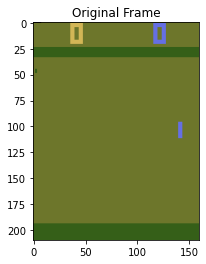

In [9]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [10]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "
2022-02-16 13:29:52.383 python[14463:604100] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb4dd6b5d30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-16 13:29:52.383 python[14463:604100] Warning: Expected min height of view: (<NSButton: 0x7fb4de319860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-16 13:29:52.384 python[14463:604100] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb4de31cb40>) to be less than

Your Score at end of game is:  -21.0


## Step 4:Preprocessing Frame

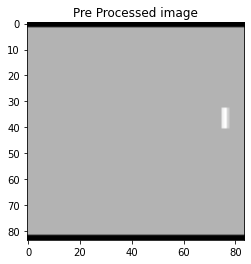

In [11]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (30, -4, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [12]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (30, -4, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [24]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

## Step 7: Watching untrained agent play

In [25]:

# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

2022-02-16 13:34:00.696 python[14463:604100] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb4de398390>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-16 13:34:00.697 python[14463:604100] Warning: Expected min height of view: (<NSButton: 0x7fb4de3ef9d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-16 13:34:00.699 python[14463:604100] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb4de3f1eb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-16 13:34:00.701 python[14463:604100] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb4de3f8110>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [26]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

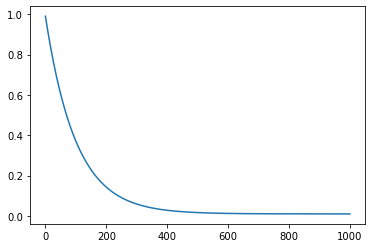

In [27]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [28]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

In [ ]:
scores = train(15)

Episode 12	Average Score: -20.33

## Step 10: Watch a Smart Agent!

In [ ]:
Liste_activation = []
agent.registration()
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render()
    action = agent.act(state)
    activ = agent.activation
    Liste_activation.append(activ)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

agent.detach()